In [17]:
#r "nuget: Yueyinqiu.Su.D2lTorchSharp, *-*"

using ScottPlot;
using System.Diagnostics;
using TorchSharp;
using Yueyinqiu.Su.D2lTorchSharp;

D2l.Notebook.PrepareAll();

Installed Packages Yueyinqiu.Su.D2lTorchSharp, 1.0.0-0.0.17

3.2.1. 生成数据集

In [18]:
(torch.Tensor X, torch.Tensor y) synthetic_data(
    torch.Tensor w, torch.Tensor b, int num_examples)
{
    using (torch.NewDisposeScope())
    {
        var X = torch.normal(0, 1, [num_examples, w.size(0)]);
        var y = torch.matmul(X, w) + b;
        y += torch.normal(0, 0.01, y.shape);
        return (X.MoveToOuterDisposeScope(), 
            y.reshape([-1, 1]).MoveToOuterDisposeScope());
    }
}

var true_w = torch.tensor(new float[] { 2, -3.4f });
var true_b = 4.2;
var (features, labels) = synthetic_data(true_w, true_b, 1000);

In [19]:
Console.WriteLine($"features: {features[0].cstr()} \nlabel: {labels[0].cstr()}");

features: [2], type = Float32, device = cpu, value = float [] {0.93069f, 1.2654f} 
label: [1], type = Float32, device = cpu, value = float [] {1.761f}



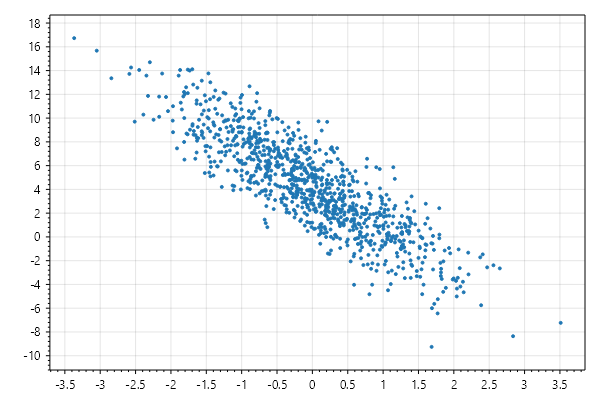

In [20]:
var plot = new Plot();
plot.Add.ScatterPoints(features[.., 1], labels.flatten(), size: 3);
plot

3.2.2. 读取数据集

In [21]:
IEnumerable<(torch.Tensor, torch.Tensor)> data_iter(
    int batch_size, torch.Tensor features, torch.Tensor labels)
{
    var num_examples = (int)features.size(0);
    var indices = D2l.PythonLike.Range(0, num_examples).ToArray();
    Random.Shared.Shuffle(indices);
    foreach(var i in D2l.PythonLike.Range(0, num_examples, batch_size))
    {
        var batch_indices_array = indices[i..Math.Min(i + batch_size, num_examples)];
        using torch.Tensor batch_indices_tensor = batch_indices_array;
        var batch_indices = torch.TensorIndex.Tensor(batch_indices_tensor);
        yield return (features[batch_indices], labels[batch_indices]);
    }
}

这里我们使用了 `D2l.PythonLike.Range` ，以使其与原文的写法保持一致。为避免产生误导，后续我们会更多地使用 `D2l.PythonLike.Range` 而不是 `Enumerable.Range` ，因为两者参数所表示的意思其实完全不同。

In [22]:
var batch_size = 10;

foreach (var (X, y) in data_iter(batch_size, features, labels))
{
    Console.WriteLine($"{X.cstr()} \n {y.cstr()}");
    break;
}

[10x2], type = Float32, device = cpu, value = 
float [,] {
 {1.2017f, 1.1724f},
 {-1.3046f, -0.87694f},
 {1.0774f, 2.6501f},
 ...
 {0.38525f, -0.0025037f},
 {-1.7039f, -0.011961f},
 {-0.70026f, -0.21489f}
} 
 [10x1], type = Float32, device = cpu, value = 
float [,] {
 {2.6185f},
 {4.5637f},
 {-2.6499f},
 ...
 {4.9866f},
 {0.82732f},
 {3.526f}
}


3.2.3. 初始化模型参数

In [23]:
var w = torch.normal(0, 0.01, size: [2, 1]).requires_grad_();
var b = torch.zeros(1, requires_grad: true);

3.2.4. 定义模型

In [24]:
torch.Tensor linreg(torch.Tensor X, torch.Tensor w, torch.Tensor b)
{
    using var matmul = torch.matmul(X, w);
    return matmul + b;
}

3.2.5. 定义损失函数

In [25]:
torch.Tensor squared_loss(torch.Tensor y_hat, torch.Tensor y)
{
    return torch.WrappedTensorDisposeScope(() => 
        (y_hat - y.reshape(y_hat.shape)).pow(2) / 2);
}

3.2.6. 定义优化算法

In [26]:
void sgd(IEnumerable<torch.Tensor> @params, double lr, int batch_size)
{
    using (torch.no_grad())
    {
        foreach (var param in @params)
        {
            using (torch.NewDisposeScope())
            {
                param.sub_(lr * param.grad() / batch_size);
                param.grad().zero_();
            }
        }
    }
}

3.2.7. 训练

In [27]:
var lr = 0.03;
var num_epochs = 3;
var net = linreg;
var loss = squared_loss;

foreach (var epoch in D2l.PythonLike.Range(num_epochs))
{
    foreach (var (X, y) in data_iter(batch_size, features, labels))
    {
        using (torch.NewDisposeScope())
        {
            var l = loss(net(X, w, b), y);
            l.sum().backward();
            sgd([w, b], lr, batch_size);
        }
    }
    using (torch.no_grad())
    {
        using (torch.NewDisposeScope())
        {
            var train_l = loss(net(features, w, b), labels);
            Console.WriteLine($"epoch {epoch + 1}, loss {(float)train_l.mean()}");
        }
    }
}

epoch 1, loss 0.029900668
epoch 2, loss 0.00010933404
epoch 3, loss 5.4173113E-05
